## SECTION 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
# 데이터셋 업로드 및 확인
import pandas as pd

url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv"
df = pd.read_csv(url)

In [3]:
# 전처리
def del_m(string): # M 지우기
    return string.replace('M','')

In [4]:
df['NA_Sales'] = df['NA_Sales'].apply(del_m)
df['EU_Sales'] = df['EU_Sales'].apply(del_m)
df['JP_Sales'] = df['JP_Sales'].apply(del_m)
df['Other_Sales'] = df['Other_Sales'].apply(del_m)

In [5]:
# 전처리 K지우고, M에 단위 맞춰주기
def deldiv_k(string):
    return str(float(string.replace('K',''))/1000)

In [6]:
index1 = df[df['NA_Sales'].str.contains('K')].index
df.iloc[index1,6] = df.iloc[index1,6].apply(deldiv_k)

index2 = df[df['EU_Sales'].str.contains('K')].index
df.iloc[index2,7] = df.iloc[index2,7].apply(deldiv_k) 

index3 = df[df['JP_Sales'].str.contains('K')].index
df.iloc[index3,8] = df.iloc[index3,8].apply(deldiv_k) 

index4 = df[df['Other_Sales'].str.contains('K')].index
df.iloc[index4,9] = df.iloc[index4,9].apply(deldiv_k) 

In [7]:
# 전처리 YEAR 네자리수로 통일

def newyear(num):
    if num <=  20:
        return num + 2000
    elif num >= 20 and num <= 100:
        return num + 1900
    else:
        return num

In [8]:
df['Year'] = df['Year'].apply(newyear)

In [9]:
mask = df['Platform'].isin(['DC', 'GEN','NG','WS','SCD','3DO','TG16','GG','PCFX'])
df = df[~mask]

In [10]:
# 형변환

df['NA_Sales'] = df['NA_Sales'].astype(float)
df['EU_Sales'] = df['EU_Sales'].astype(float)
df['JP_Sales'] = df['JP_Sales'].astype(float)
df['Other_Sales'] = df['Other_Sales'].astype(float)

In [11]:
df['Sales_Total'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

In [12]:
# anova 검정
an1 = pd.crosstab(index = 'NA_Sales', columns = df['Genre'], values = df['NA_Sales'], aggfunc = np.sum).fillna(0)
an2 = pd.crosstab(index = 'EU_Sales', columns = df['Genre'], values = df['EU_Sales'], aggfunc = np.sum).fillna(0)
an3 = pd.crosstab(index = 'JP_Sales', columns = df['Genre'], values = df['JP_Sales'], aggfunc = np.sum).fillna(0)
an4 = pd.crosstab(index = 'Other_Sales', columns = df['Genre'], values = df['Other_Sales'], aggfunc = np.sum).fillna(0)


In [13]:
j1 = an1 .iloc[0].tolist()
j2 = an2 .iloc[0].tolist()
j3 = an3.iloc[0].tolist()
j4 = an4 .iloc[0].tolist()

In [15]:
from scipy.stats import f_oneway
f_oneway(j1, j2, j3, j4)
# 귀무가설 : 지역별 선호 장르는 모두 동일하다
# 대립가설 : 지역별 선호 장르는 모두 동일하지 않다.
# p값 0.05 이하이므로 귀무가설 기각, 대립가설 채택

F_onewayResult(statistic=9.018655045149751, pvalue=9.050356038403072e-05)

In [18]:
newdata = pd.concat([an1, an2, an3, an4]) 
newdata

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
row_0,,,,,,,,,,,,
NA_Sales,872.54,105.14,219.22,408.05,433.45,123.35,356.09,319.54,581.92,182.96,675.68,68.70
EU_Sales,521.38,63.81,100.02,212.36,197.26,50.73,236.59,183.58,313.05,113.35,375.99,45.32
JP_Sales,157.06,49.86,83.55,105.15,129.17,56.85,55.11,342.69,37.80,63.16,133.94,48.93
Other_Sales,186.34,16.77,36.47,74.04,50.84,12.52,77.02,56.96,102.65,31.48,134.55,11.36


In [19]:
# 지역별 바차트 그리기
def draw_group_barchart(df,main_category,sub_category,fig_width=10,fig_height=5, \
                        bar_type='vertical', between_bar_padding=0.85,\
                        within_bar_padding=0.8, config_bar=None):
    '''
    Description :
    그룹바 차트를 그려주는 함수다. 
    
    Arguments :
    df = 메인 카테고리와 서브 카테고리로 이루어진 데이터, pd.DataFrame 객체여야 한다.
    main_category = 메인 카테고리 변수를 나타내는 문자열
    sub_category = 서브 카테고리 변수를 모아 놓은 리스트
    fig_width = 캔버스 폭
    fig_height = 캔버스 높이
    bar_type = 'vertical' 또는 'horizontal'값을 가질 수 있으며
               'vertical'은 수직 바 차트를 'horizontal'은 수평 바 차트를 그린다.
    between_bar_padding = 메인 카테고리 간 여백 조절 0~1사이의 값을 갖는다.
    within_bar_padding = 메인 카테고리 내 여백 조절 0~1사이의 값을 갖는다. 
    config_bar = 바 차트를 꾸미기 위한 옵션. 딕셔너리 형태로 넣어줘야 한다.
    
    Return : 
    그룹바 차트 출력
    '''
    
    ## Arguments 체크
    if not isinstance(main_category,str):
        print(f'main_category인자의 타입은 {type(main_category)}가 아니고 문자열 입니다.')
        return
    if not main_category in df.columns:
        print(f'데이터가 {main_category} 칼럼을 포함하고 있지 않습니다.')
        return
    if not set(sub_category).issubset(set(df.columns)):
        print(f'{set(sub_category)-set(df.columns)}가 데이터에 없습니다.')
        return
    if isinstance(bar_type,str):
        if not bar_type in ['vertical','horizontal']:
            print(f'bar_type인자에는 "vertical"과 "horizontal"만 허용됩니다.')
            return
    else:
        print(f'bar_type인자의 타입은 {type(bar_type)}가 아니고 문자열 입니다.')
        return
    
    if between_bar_padding < 0 or between_bar_padding > 1:
        print(f'between_bar_padding은 0보다 크거나 같고, 1보다 작거나 같아야합니다.')
        return
    if within_bar_padding < 0 or within_bar_padding > 1:
        print(f'within_bar_padding은 0보다 크거나 같고, 1보다 작거나 같아야합니다.')
        return
    
    ## 필요 모듈 임포트
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    %matplotlib inline 
 
    num_sub_category = len(sub_category) ## 서브 카테고리 개수
 
    fig = plt.figure(figsize=(fig_width,fig_height)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 지정
    ax = fig.add_subplot() ## 그림이 그려질 축을 생성
    
    colors = sns.color_palette('hls',num_sub_category) ## 막대기 색상 지정
    
    tick_label = list(df[main_category].unique()) ## 메인 카테고리 라벨 생성
    tick_number = len(tick_label) ## 메인 카테고리 눈금 개수
    
    tick_coord = np.arange(tick_number) ## 메인 카테고리안에서 첫번째 서브 카테고리 막대기가 그려지는 x좌표
 
    width = 1/num_sub_category*between_bar_padding ## 막대기 폭 지정
 
    config_tick = dict()
    config_tick['ticks'] = [t + width*(num_sub_category-1)/2 for t in tick_coord] ## 메인 카테고리 라벨 x좌표
    config_tick['labels'] = tick_label 
 
    if bar_type == 'vertical': ## 수직 바 차트를 그린다.
        plt.xticks(**config_tick) ## x축 눈금 라벨 생성
 
        for i in range(num_sub_category):
            if config_bar: ## 바 차트 추가 옵션이 있는 경우
                ax.bar(tick_coord+width*i, df[sub_category[i]], \
                       width*within_bar_padding, label=sub_category[i], \
                       color=colors[i], **config_bar) ## 수직 바 차트 생성
            else:
                ax.bar(tick_coord+width*i, df[sub_category[i]], \
                       width*within_bar_padding, label=sub_category[i], \
                       color=colors[i]) ## 수직 바 차트 생성
        plt.legend() ## 범례 생성
        plt.savefig('fig03.png',format='png',dpi=300)
        plt.show()
    else: ## 수평 바 차트를 그린다.
        plt.yticks(**config_tick) ## x축 눈금 라벨 생성
 
        for i in range(num_sub_category):
            if config_bar: # 바 차트 추가 옵션이 있는 경우
                ax.barh(tick_coord+width*i, df[sub_category[i]], \
                       width*within_bar_padding, label=sub_category[i], \
                        color=colors[i], **config_bar) ## 수평 바 차트 생성
            else:
                ax.barh(tick_coord+width*i, df[sub_category[i]], \
                       width*within_bar_padding, label=sub_category[i], \
                       color=colors[i]) ## 수평 바 차트 생성
        plt.legend() ## 범례 생성
        plt.show()

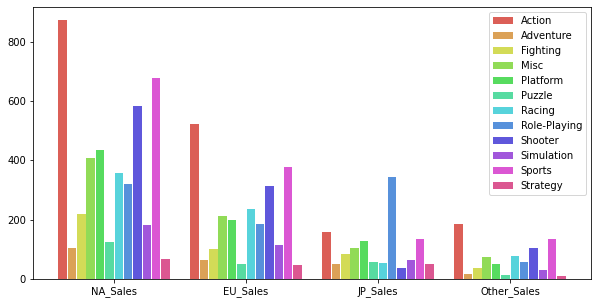

In [20]:
nnewdata = newdata.iloc[:,:]
nnewdata['local'] = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

main_category = 'local'
sub_category = ['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy']

draw_group_barchart(nnewdata,main_category,sub_category,\
                        bar_type='vertical', between_bar_padding=0.85,\
                        within_bar_padding=0.9, config_bar = None)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
newdata2_ed = pd.read_excel('/content/drive/MyDrive/test/newdata2_ed.xlsx')

In [28]:
newdata2_ed.set_index('Year', inplace=True)

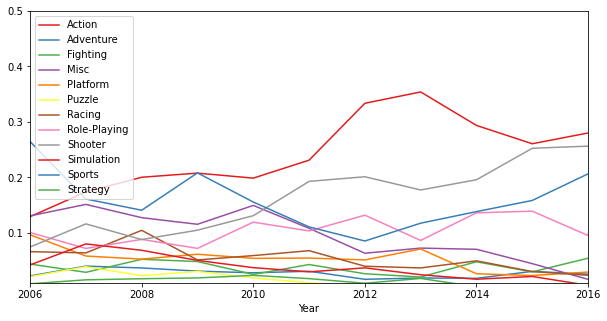

In [29]:
# 장르별 트렌드 확인

plt.rcParams['figure.figsize'] = [10, 5]
plt.xlim(2006,2016)
plt.ylim(0.01,0.5)
sns.lineplot(data = newdata2_ed, palette='Set1', dashes = False, alpha = 1);

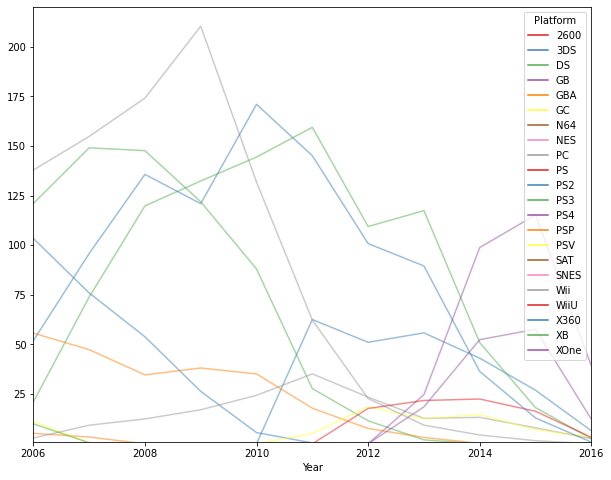

In [30]:
# 플랫폼별 트렌드 확인
newdata3 = pd.crosstab(index = df['Year'], columns = df['Platform'], values = df['Sales_Total'], aggfunc = np.sum).fillna(0)
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlim(2006,2016)
plt.ylim(1,220)
sns.lineplot(data = newdata3, palette='Set1', dashes = False, alpha = 0.5);

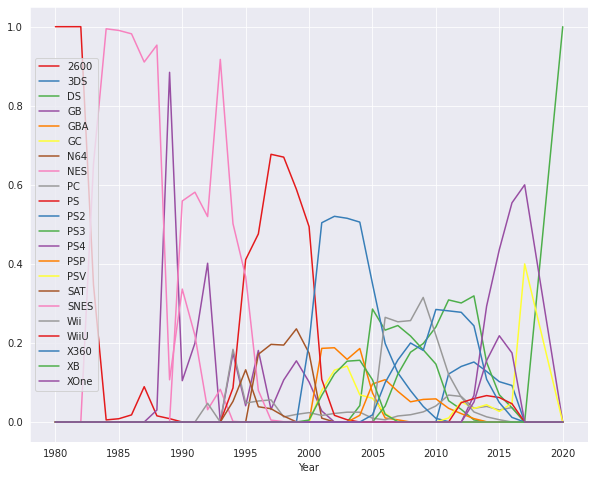

In [31]:
newdata3_ed = pd.read_excel('/content/drive/MyDrive/test/newdata3_ed.xlsx')
newdata3_ed.set_index('Year', inplace=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [10, 8]
sns.lineplot(data = newdata3_ed,  palette= "Set1", dashes = False, legend='auto', alpha = 1);


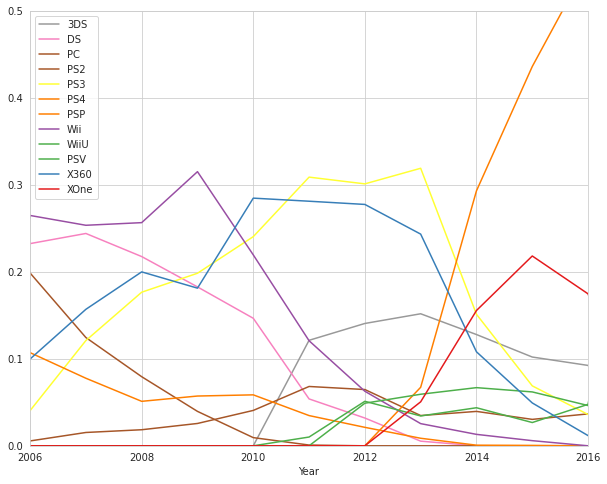

In [32]:
newdata4 = newdata3_ed[['3DS','DS','PC','PS2','PS3', 'PS4', 'PSP','Wii', 'WiiU', 'PSV','X360','XOne']]
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 8]
plt.ylim(0,0.5)
plt.xlim(2006,2016) 
sns.lineplot(data = newdata4,  palette= "Set1_r", dashes = False, legend='auto', alpha = 1);

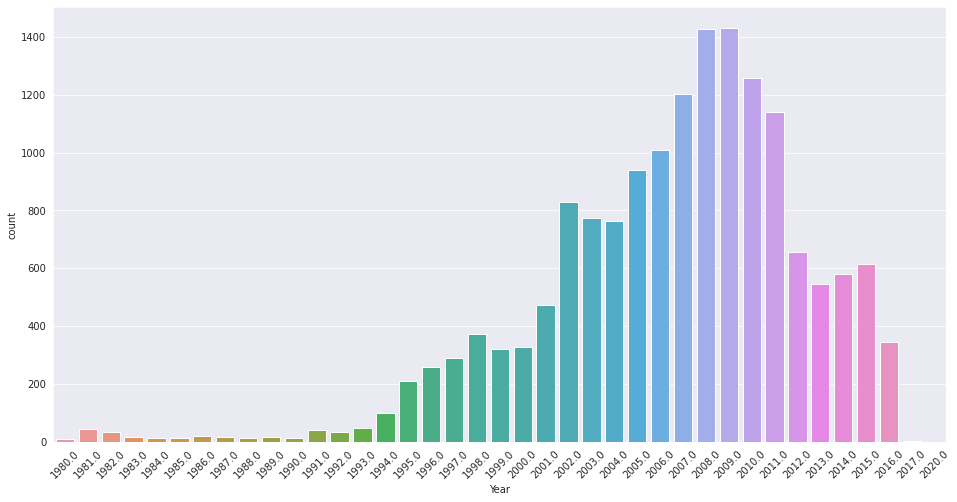

In [34]:
# 연도별 데이터수 확인(2017년도부터 거의 없음. 자료를 넣으면 비율 정보가 왜곡)
fig = plt.figure(figsize=(16,8)) ## 캔버스 생성
fig.set_facecolor('white')
plt.xticks(rotation=45)
sns.countplot(x='Year', data = df)

In [36]:
# 100위내 인기게임 장르 조사
df_group = df.groupby('Name').sum()
df_group = df_group.drop(['Unnamed: 0','Year'], axis=1)

df_m = df[['Name','Genre','Year']]
df_m.drop_duplicates(['Name'], keep = 'first')

df_nice = df_group.merge(df_m, how = 'inner', on = 'Name')
df_nice

df_lll = df_nice.drop_duplicates(['Sales_Total'], keep = 'first')

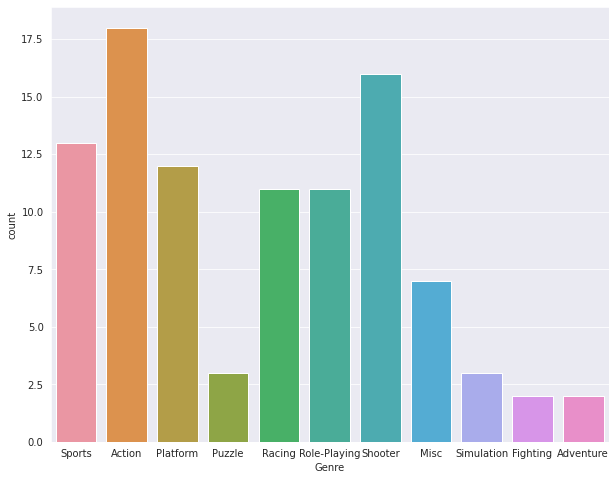

In [39]:
df_glob_100 = df_lll.sort_values(by=["Sales_Total"], ascending=[False])
df_glob_100 = df_glob_100.iloc[0:100, :]
sns.countplot(x='Genre', data = df_glob_100)

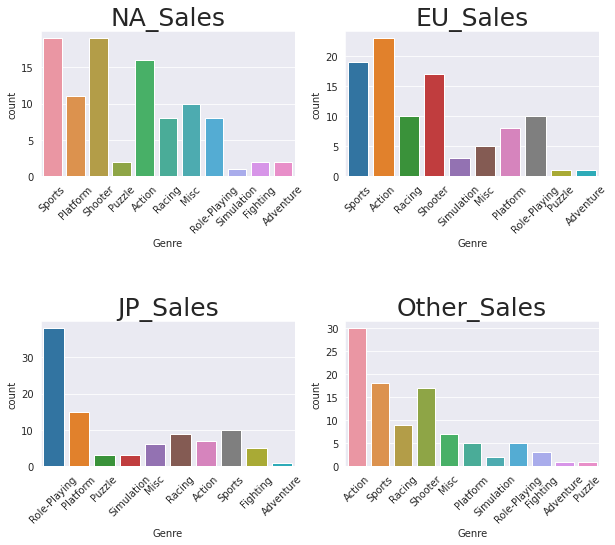

In [40]:
# 100위내 인기게임 장르 조사
df_na_100 = df_lll.sort_values(by=["NA_Sales"], ascending=[False])
df_na_100 = df_na_100.iloc[0:100, :]
plt.subplot(2, 2, 1)
plt.xticks(rotation=45)
plt.title('NA_Sales' , fontsize=25)
sns.countplot(x='Genre', data = df_na_100)

df_eu_100 = df_lll.sort_values(by=["EU_Sales"], ascending=[False])
df_eu_100 = df_eu_100.iloc[0:100, :]
plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
plt.title('EU_Sales' , fontsize=25)
sns.countplot(x='Genre', data = df_eu_100)

df_jp_100 = df_lll.sort_values(by=["JP_Sales"], ascending=[False])
df_jp_100 = df_jp_100.iloc[0:100, :]
plt.subplot(2, 2, 3)
plt.xticks(rotation=45)
plt.title('JP_Sales' , fontsize=25)
sns.countplot(x='Genre', data = df_jp_100)

df_ot_100 = df_lll.sort_values(by=["Other_Sales"], ascending=[False])
df_ot_100 = df_ot_100.iloc[0:100, :]
plt.subplot(2, 2, 4)
plt.xticks(rotation=45)
plt.title('Other_Sales' , fontsize=25)
sns.countplot(x='Genre', data = df_ot_100)
plt.subplots_adjust(hspace=1)


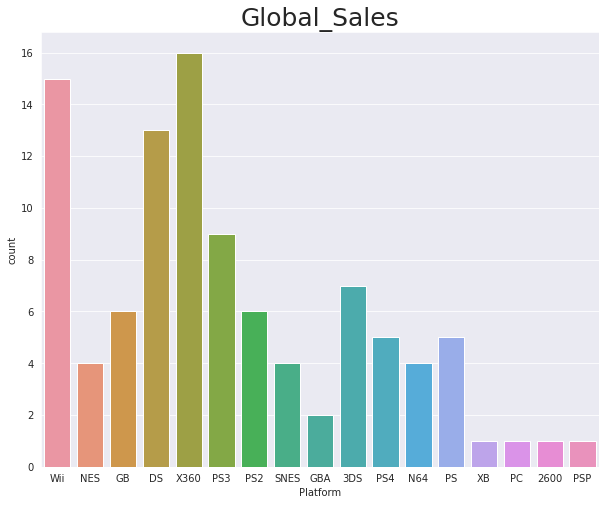

In [41]:
# 100위내 인기게임 플랫폼 조사
df_pl = df.groupby('Platform').sum()
df_pl = df_pl.drop(['Unnamed: 0','Year'], axis=1)
df_gl_pl = df.sort_values(by=["Sales_Total"], ascending=[False])
df_gl_pl = df_gl_pl.iloc[0:100, :]
plt.title('Global_Sales' , fontsize=25)
sns.countplot(x='Platform', data = df_gl_pl)

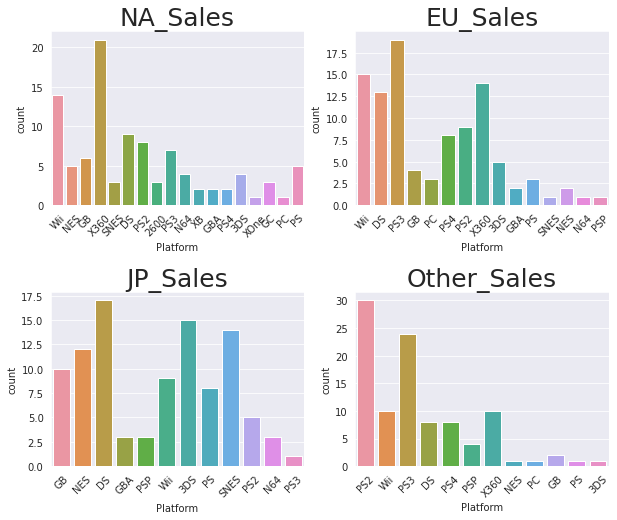

In [42]:
# 100위내 인기게임 플랫폼 조사
df_na_pl = df.sort_values(by=["NA_Sales"], ascending=[False])
df_na_pl = df_na_pl.iloc[0:100, :]
plt.subplot(2, 2, 1)
plt.xticks(rotation=45)
plt.title('NA_Sales' , fontsize=25)
sns.countplot(x='Platform', data = df_na_pl)

df_eu_pl = df.sort_values(by=["EU_Sales"], ascending=[False])
df_eu_pl = df_eu_pl.iloc[0:100, :]
plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
plt.title('EU_Sales' , fontsize=25)
sns.countplot(x='Platform', data = df_eu_pl)

df_jp_pl = df.sort_values(by=["JP_Sales"], ascending=[False])
df_jp_pl = df_jp_pl.iloc[0:100, :]
plt.subplot(2, 2, 3)
plt.xticks(rotation=45)
plt.title('JP_Sales' , fontsize=25)
sns.countplot(x='Platform', data = df_jp_pl)

df_ot_pl = df.sort_values(by=["Other_Sales"], ascending=[False])
df_ot_pl = df_ot_pl.iloc[0:100, :]
plt.subplot(2, 2, 4)
plt.xticks(rotation=45)
plt.title('Other_Sales' , fontsize=25)
sns.countplot(x='Platform', data = df_ot_pl)

plt.subplots_adjust(hspace=0.5)

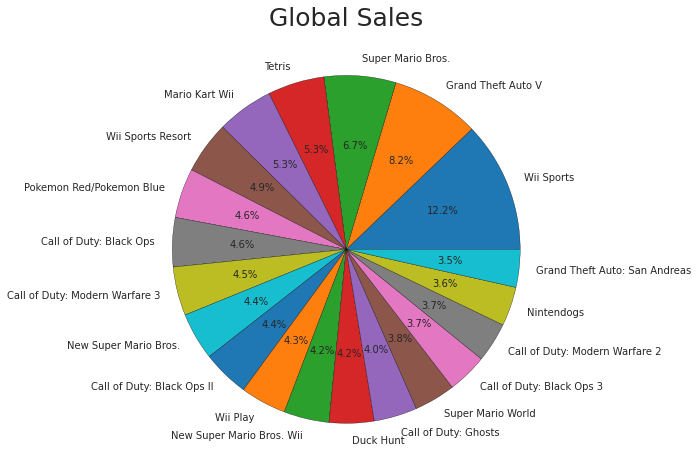

In [45]:
# 전세계에서 가장 출고량 높은 게임들

df_pop = df_group.sort_values(by=["Sales_Total"], ascending=[False])
df_pop = df_pop.iloc[0:20, :]
ratio = df_pop['Sales_Total']
labels = df_pop.index
plt.title('Global Sales', fontsize=25)
plt.pie(ratio, labels=labels, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

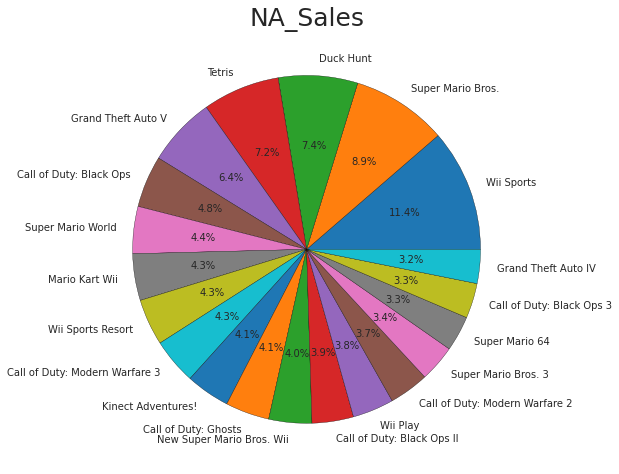

In [46]:
# 북미에서 가장 출고량 높은 게임들
df_pop_na = df_group.sort_values(by=['NA_Sales'], ascending=[False])
df_pop_na = df_pop_na.iloc[0:20, :]

ratio_na = df_pop_na['NA_Sales']
labels_na = df_pop_na.index
plt.title('NA_Sales' , fontsize=25)
plt.pie(ratio_na, labels=labels_na, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

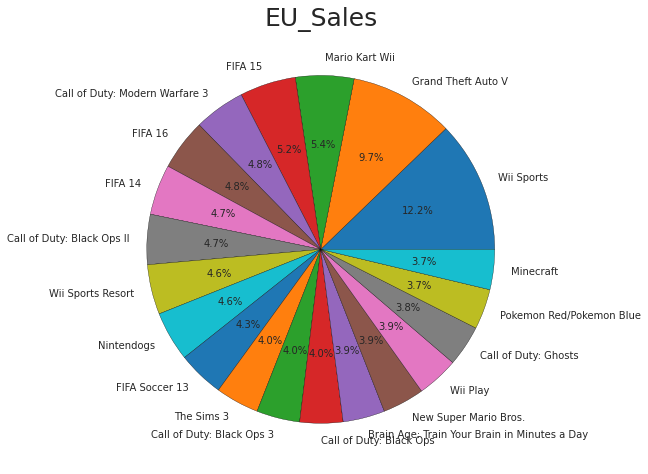

In [47]:
# 유럽에서 가장 출고량 높은 게임들
df_pop_eu = df_group.sort_values(by=['EU_Sales'], ascending=[False])
df_pop_eu = df_pop_eu.iloc[0:20, :]

ratio_eu = df_pop_eu['EU_Sales']
labels_eu = df_pop_eu.index
plt.title('EU_Sales' , fontsize=25)
plt.pie(ratio_eu, labels=labels_eu, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

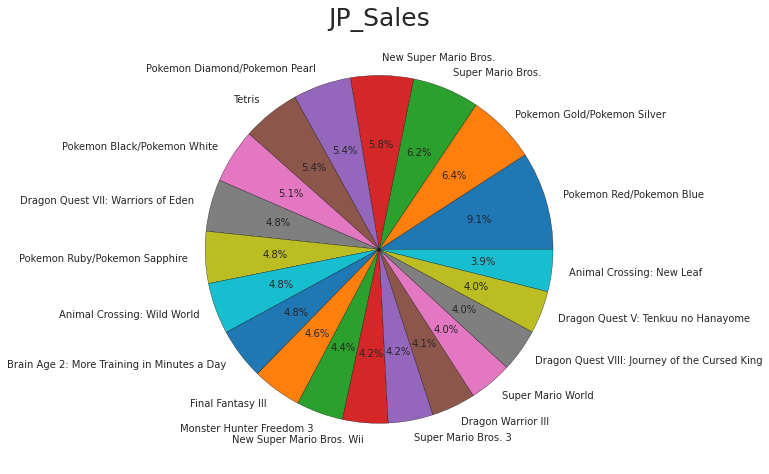

In [49]:
# 일본에서 가장 출고량 높은 게임들
df_pop_jp = df_group.sort_values(by=['JP_Sales'], ascending=[False])
df_pop_jp = df_pop_jp.iloc[0:20, :]

ratio_jp = df_pop_jp['JP_Sales']
labels_jp = df_pop_jp.index
plt.title('JP_Sales' , fontsize=25)
plt.pie(ratio_jp, labels=labels_jp, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

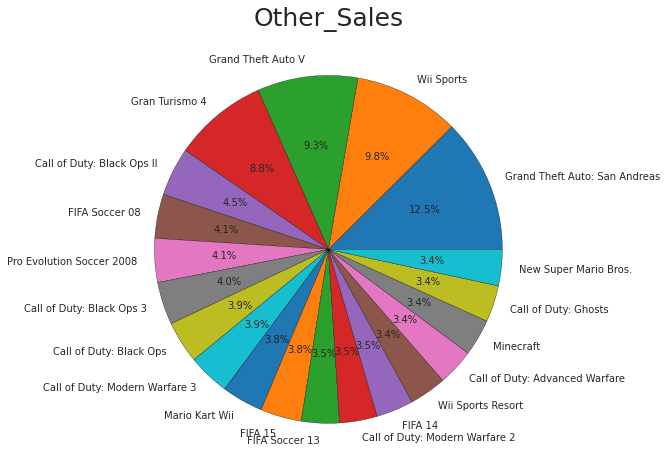

In [48]:
# 기타지역에서 가장 출고량 높은 게임들
df_pop_ot = df_group.sort_values(by=['Other_Sales'], ascending=[False])
df_pop_ot = df_pop_ot.iloc[0:20, :]

ratio_ot = df_pop_ot['Other_Sales']
labels_ot = df_pop_ot.index
plt.title('Other_Sales' , fontsize=25)
plt.pie(ratio_ot, labels=labels_ot, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

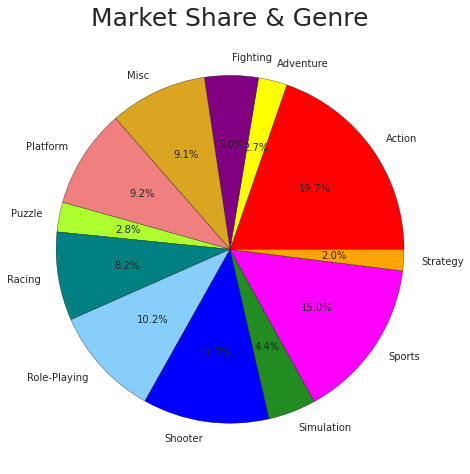

In [50]:
# 플랫폼별 출고량 점유율
newdata6 = df.groupby('Genre').sum()
newdata6  = newdata6 .drop(['Unnamed: 0','Year'], axis=1)
newdata6['share'] = newdata6['Sales_Total']*100/newdata6['Sales_Total'].sum()

ratio = newdata6['share']
labels = newdata6.index
plt.title('Market Share & Genre' , fontsize=25)
plt.pie(ratio, labels=labels, colors = ['red','yellow','purple','goldenrod','lightcoral','greenyellow','teal','lightskyblue','blue','forestgreen','fuchsia','orange'] , autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()

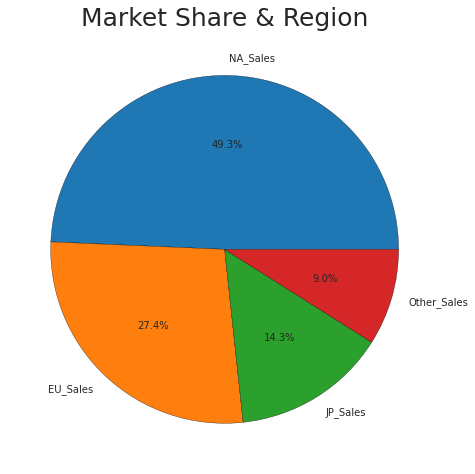

In [51]:
# 지역별 출고량 점유율
ratio = [49.31, 27.38,14.33,8.97]
labels = ['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']
plt.title('Market Share & Region' , fontsize=25)
plt.pie(ratio, labels=labels, autopct='%.1f%%', wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':0.3})
plt.show()